### Note: Place code in directory, with the folder for images and a folder for output files on the same level.

In [1]:
# Importing modules to build, train, and test model
import os
import stat
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import numpy as np
import imageio as im
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import math
import PIL
from PIL import Image

# Importing modules to build heatmap
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras import initializers
from keras.models import Model
import matplotlib.cm as cm
import random

from tensorflow.keras.applications import imagenet_utils
import h5py

from vis.visualization import overlay,visualize_cam,visualize_activation,visualize_saliency
from vis.utils import utils

print("All loaded!")

Using TensorFlow backend.


All loaded!


Importing modules to find image files, convert to usable image data, and build the CNN.
#  

In [2]:
# Clearing the memory for a fresh start and prevention of slowdown
tf.keras.backend.clear_session()

In [3]:
classifier = Sequential()

# Adding the first convolutional layer
classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (256, 256, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 2, activation = 'softmax', name='visualized_layer')) 
                     # Note that the units here should
                     # be equal to number of classes

In [4]:
# Simply prints an overview of the model
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)       

In [5]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [6]:
# Defining directories to make easier to reference later on:

cwd = os.getcwd()
training_dir = cwd + "\images\\training"
testing_dir = cwd + "\images\\testing"
validation_dir = cwd + "\images\\validation"
output_dir = cwd + "\output"
weights_dir = '\outputs\\boiling_weights.hdf5'
classifier_dir = cwd + "\outputs\\boiling_model.h5"
#output_dir = "/images"

In [7]:
print(cwd)
print(training_dir)
print(testing_dir)
print(validation_dir)

C:\Users\cheo2\Box\Nano Energy Lab Shared Folder\Connor\Machine Learning\High speed videos of boiling and Code
C:\Users\cheo2\Box\Nano Energy Lab Shared Folder\Connor\Machine Learning\High speed videos of boiling and Code\images\training
C:\Users\cheo2\Box\Nano Energy Lab Shared Folder\Connor\Machine Learning\High speed videos of boiling and Code\images\testing
C:\Users\cheo2\Box\Nano Energy Lab Shared Folder\Connor\Machine Learning\High speed videos of boiling and Code\images\validation


To use the 'flow_from_directory' function, you need two folders, one for training and one for testing. In each of these folders, you need one folder for each class.

In [8]:
# Creating (and downscaling) the location for the image data to be stored
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Setting the image/batch parameters to change easily if need be
# Certain parameters later on typically depend on these values
image_width = 256
image_height = 256
batch_size = 25

# Taking in the image data from a given directory
# The classes are automatically set based on how the folders are arranged
training_set = train_datagen.flow_from_directory(training_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(testing_dir,
                                            target_size = (image_width, image_height),
                                            batch_size = batch_size,
                                            shuffle=True,
                                            class_mode = 'categorical')

validation_set = val_datagen.flow_from_directory(validation_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode = 'categorical')

D:\Anaconda\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The training and testing and validatoin sets are now created from the images separated into 2 classes.
#   

In [9]:
# Setting up a checkpoint such that after every cycle of the CNN, 
# the best parameters (weights) will be saved
checkpointer = ModelCheckpoint(filepath="boiling_weights.hdf5", 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

In [11]:
print(math.ceil(training_set.n/training_set.batch_size))

320


In [31]:
# As mentioned above, certain parameters of the model are based on ratios between the size
# of the samples, batch, etc.

# Number of epochs is kept relatively low (to run quicker and diagnose problems), 
# but can be increased for actual use later on
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = math.ceil(training_set.n/training_set.batch_size),
                                   epochs = 5,
                                   callbacks=[checkpointer],
                                   validation_data = test_set,
                                   validation_steps = math.ceil(validation_set.n/validation_set.batch_size),
                                   shuffle=True)

Epoch 1/5
320/320 [==============================] - 726s 2s/step - loss: 0.5132 - accuracy: 0.9344 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00001: loss improved from inf to 0.51322, saving model to boiling_weights.hdf5
Epoch 2/5
 16/320 [>.............................] - ETA: 10:46 - loss: 1.6093e-08 - accuracy: 1.0000

KeyboardInterrupt: 

Notes: steps_per_epoch is usually equal to ceil(num_samples/batch_size) and validation_steps is the same, with the size of the test dataset instead of the training dataset.

In [10]:
# Saving the model and the weights found by the CNN
classifier_dir = os.path.dirname(os.path.abspath('boiling_model.hdf5'))
#classifier_dir = cwd + "\Output Files"
classifier.load_weights('boiling_weights.hdf5')
classifier.save('boiling_model.h5')

In [11]:
# Evaluating the model ("classifier")
scores = classifier.evaluate_generator(validation_set,verbose=1)
print(scores)

40/40 [==============================] - 35s 864ms/step
[0.0, 1.0]


In [12]:
# Saving the name of the final layer to a variable for easy reference
layer_idx = utils.find_layer_idx(classifier, 'dense_1')

# Changing the final layer from softmax to linear
classifier.layers[layer_idx].activation = activations.linear
classifier = utils.apply_modifications(classifier)

Random indices in each class:  [6, 17]
Predicted class is: [0]


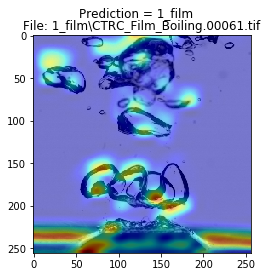

Predicted class is: [0]


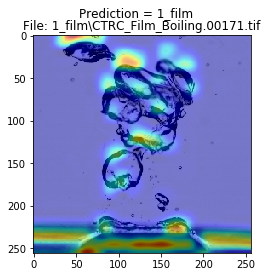

In [35]:
# Grabbing images by random index from the testing set, one random image per class
random.seed()
ids_to_visualize = [random.randint(0,9),
                    random.randint(10,19)]
                    
print("Random indices in each class: ",ids_to_visualize)

# Saving the name of the final layer to a variable for easy reference
layer_idx = utils.find_layer_idx(classifier, 'dense_1')

# Changing the final layer from softmax to linear
classifier.layers[layer_idx].activation = activations.linear
classifier = utils.apply_modifications(classifier)

for i in range(len(ids_to_visualize)):
    test_set.reset()
    index = ids_to_visualize[i]
    image.ImageDataGenerator()
    img_path = test_set.filepaths[index]
    img = image.load_img(img_path, target_size=(image_width, image_height))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size=10)
    print("Predicted class is:",classes)
    
    visualization = visualize_cam(classifier, layer_idx, filter_indices=0, 
                                  seed_input=img_tensor[0,:,:,:])
    
    heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
    original = np.uint8(cm.gray(img_tensor[..., 0])[..., :3] * 255)
    
    # Re-sizing original image to fit with the heatmap image
    original_resized = np.reshape(original,(image_width, image_height,3));
    plt.imshow(overlay(heatmap,original_resized))
    plt.title('File: ' + test_set.filenames[index])
    plt.suptitle(f'Prediction = {list(test_set.class_indices.items())[classes[0]][0]}')
    #filename = output_dir + '\overlay' + str(i+1) + '.png'
    filename = training_set.filenames[index]
    filename = filename[:-4]
    name_split = filename.split("\\")
    filename = output_dir + "\\" + name_split[1] + "_overlay.png"
    #plt.savefig(filename, bbox_inches='tight')
    plt.show()

Random indices:  [2, 14]
Predicted class is: [0]


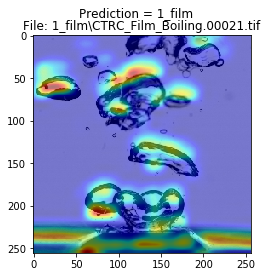

Predicted class is: [0]


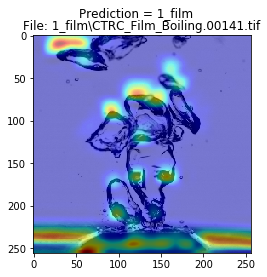

In [36]:
# Grabbing images by random index from the testing set, 4 completely random images
random.seed()
ids_to_visualize = [random.randint(0,19),
                    random.randint(0,19)]

print("Random indices: ",ids_to_visualize)

# Saving the name of the final layer to a variable for easy reference
layer_idx = utils.find_layer_idx(classifier, 'dense_1')

# Changing the final layer from softmax to linear
classifier.layers[layer_idx].activation = activations.linear
classifier = utils.apply_modifications(classifier)

for i in range(len(ids_to_visualize)):
    test_set.reset()
    index = ids_to_visualize[i]
    image.ImageDataGenerator()
    img_path = test_set.filepaths[index]
    img = image.load_img(img_path, target_size=(image_width, image_height))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size=10)
    print("Predicted class is:",classes)
    
    visualization = visualize_cam(classifier, layer_idx, filter_indices=0, 
                                  seed_input=img_tensor[0,:,:,:])

    heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
    original = np.uint8(cm.gray(img_tensor[..., 0])[..., :3] * 255)
    
    # Re-sizing original image to fit with the heatmap image
    original_resized = np.reshape(original,(image_width, image_height,3));
    plt.imshow(overlay(heatmap,original_resized))
    plt.title('File: ' + test_set.filenames[index])
    plt.suptitle(f'Prediction = {list(test_set.class_indices.items())[classes[0]][0]}')
    plt.show()

In [37]:
# Implementing a graph of accuracy (both training and testing) vs. epoch number, to see what a good number
# of epochs is to reach convergence:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc_scaled = [i * 100 for i in acc]
val_acc_scaled = [i * 100 for i in val_acc]

epochs = range(1, len(acc) + 1)

matplotlib.rcParams['font.sans-serif'] = "Calibri"
matplotlib.rcParams['font.family'] = "sans-serif"

rect = [0.0, 0.0, 2.0, 2.0]
#fig = figure(1, figsize=(10,6))
ax1 = plt.axes(rect)
plt.rc('font', size = 22)
plt.plot(epochs, acc_scaled, 'ro:', label='Training Acc')
plt.plot(epochs, val_acc_scaled, 'bo:', label='Validation Acc')
plt.xticks(range(0,21))
plt.xlabel('Epoch')
plt.yticks(range(40,101,10))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
plt.show()

ax2 = plt.axes(rect)
#figure(1, figsize=(10,6))
plt.plot(epochs, loss, 'ro:', label='Training Loss')
plt.plot(epochs, val_loss, 'bo:', label='Validation Loss')
plt.xticks(range(0,21))
plt.xlabel('Epoch')
plt.yticks(np.arange(0.0,1.5,0.1))
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Training_Validation_Loss.png',bbox_inches='tight')
plt.show()

NameError: name 'history' is not defined

In [38]:
# Testing visualization of each layer:

# Grabbing images by random index from the testing set, 4 completely random images
random.seed()

ids_to_visualize = [random.randint(0,19)]

print("Random index: ",ids_to_visualize)

# Saving the name of the final layer to a variable for easy reference
layer_idx = utils.find_layer_idx(classifier, 'dense_1')

# Changing the final layer from softmax to linear
classifier.layers[layer_idx].activation = activations.linear
classifier = utils.apply_modifications(classifier)

for i in range(len(ids_to_visualize)):
    test_set.reset()
    index = ids_to_visualize[i]
    image.ImageDataGenerator()
    img_path = test_set.filepaths[index]
    img = image.load_img(img_path, target_size=(image_width, image_height))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    print(img_tensor.shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size=10)
    #print("Predicted class is:",classes)
    
    visualization = visualize_cam(classifier, layer_idx, filter_indices=0, 
                                  seed_input=img_tensor[0,:,:,:])

    heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
    original = np.uint8(cm.gray(img_tensor[..., 0])[..., :3] * 255)
    
    layer_outputs = [layer.output for layer in classifier.layers[:16]]
    
    activation_model = Model(inputs=classifier.input, outputs=layer_outputs)

Random index:  [16]
(1, 256, 256, 3)


(1, 256, 256, 32)


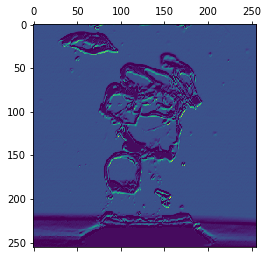

In [39]:
activation_vis = activation_model.predict(img_tensor)
first_layer_act = activation_vis[0]
print(first_layer_act.shape)

plt.matshow(first_layer_act[0,:,:,3], cmap='viridis')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


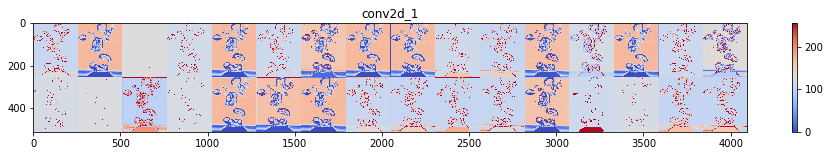

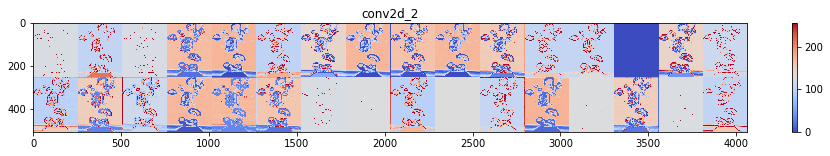

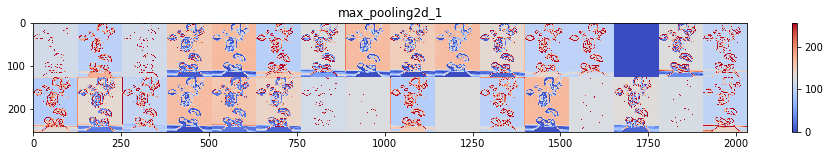

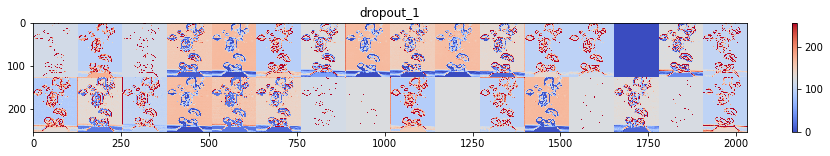

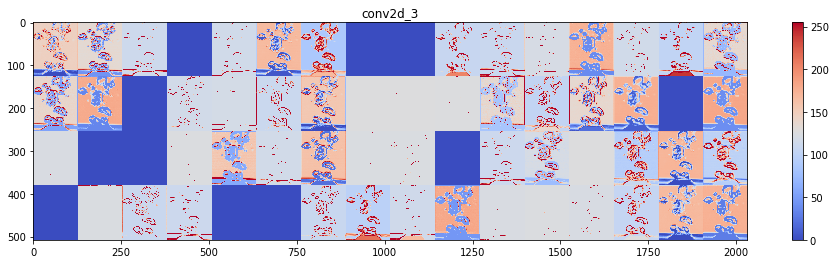

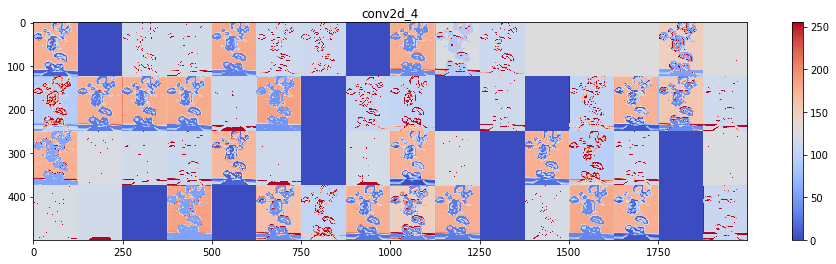

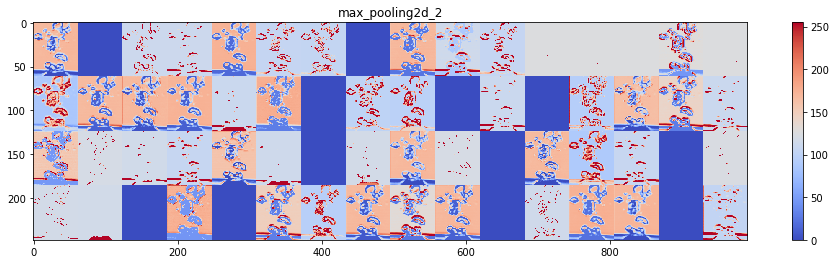

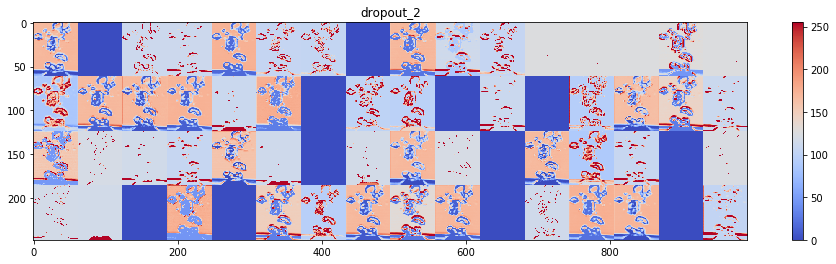

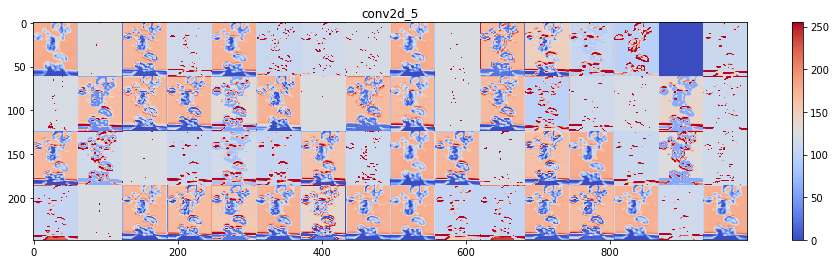

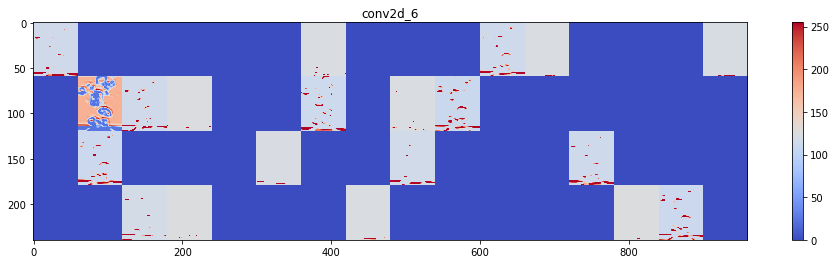

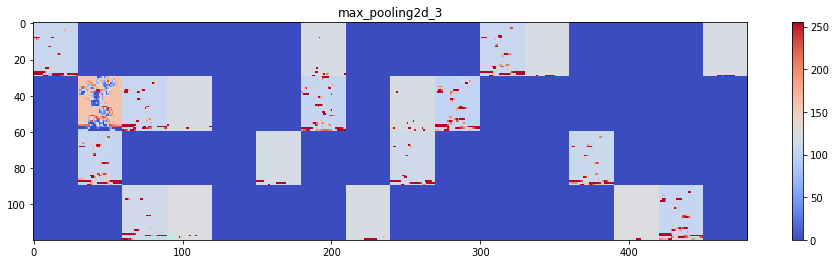

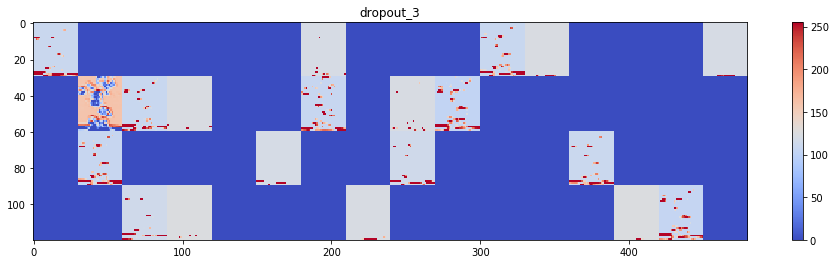

In [21]:
layer_names = []
for layer in classifier.layers[:12]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activation_vis): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='coolwarm')
    plt.colorbar();

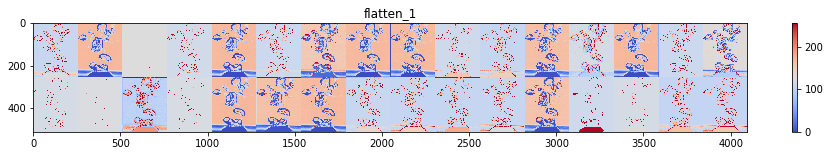

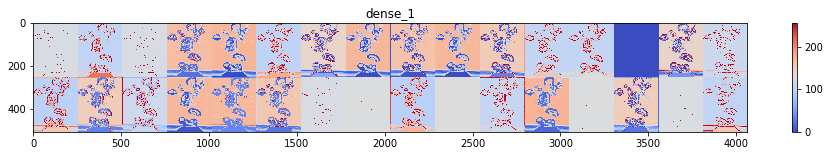

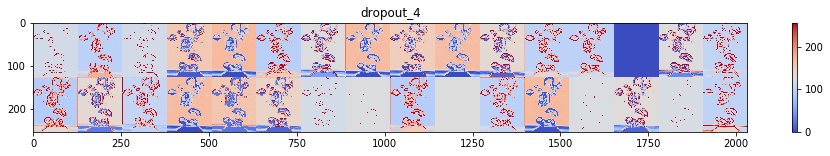

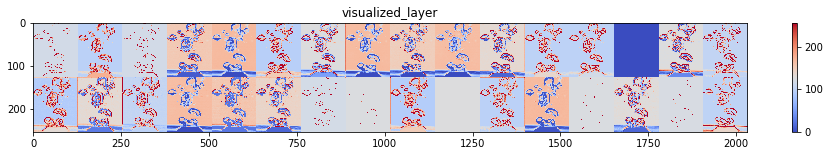

In [22]:
layer_names = []
for layer in classifier.layers[12:16]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activation_vis): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='coolwarm')
    plt.colorbar();

In [23]:
from vis.visualization import visualize_activation

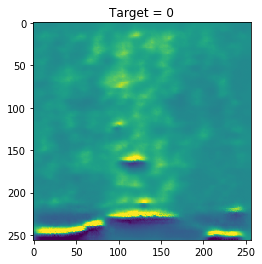

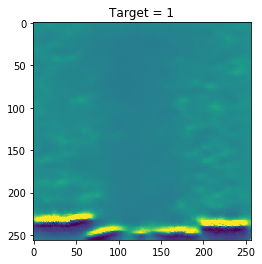

In [40]:
# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(classifier, 'visualized_layer')

# Swap softmax with linear
classifier.layers[layer_index].activation = activations.linear
classifier = utils.apply_modifications(classifier)  

class_to_visualize = [0, 1]

for class_to_visualize in class_to_visualize:
    visualization = visualize_activation(classifier, layer_index, filter_indices=class_to_visualize)
    plt.imshow(visualization[...,0])
    plt.title(f'Target = {class_to_visualize}')
    plt.show()

All done!


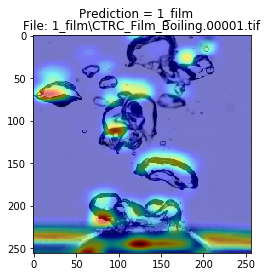

In [16]:
# Loop to save heatmaps for all testing images
ids_to_visualize = [0]

# Saving the name of the final layer to a variable for easy reference
layer_idx = utils.find_layer_idx(classifier, 'dense_1')

# Changing the final layer from softmax to linear
classifier.layers[layer_idx].activation = activations.linear
classifier = utils.apply_modifications(classifier)

for i in range(len(ids_to_visualize)):
    test_set.reset()
    index = ids_to_visualize[i]
    image.ImageDataGenerator()
    img_path = test_set.filepaths[index]
    img = image.load_img(img_path, target_size=(image_width, image_height))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size=10)
    #print("Predicted class is:",classes)
    
    visualization = visualize_cam(classifier, layer_idx, filter_indices=0, 
                                  seed_input=img_tensor[0,:,:,:])
    
    heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
    original = np.uint8(cm.gray(img_tensor[..., 0])[..., :3] * 255)
    
    # Re-sizing original image to fit with the heatmap image
    original_resized = np.reshape(original,(image_width, image_height,3));
    
    # Adding the filename and predicted class to the header, and saving the figure
    plt.imshow(overlay(heatmap,original_resized))
    plt.title('File: ' + test_set.filenames[index])
    plt.suptitle(f'Prediction = {list(test_set.class_indices.items())[classes[0]][0]}')
    filename = training_set.filenames[index]
    filename = filename[:-4]
    name_split = filename.split("\\")
    filename = output_dir + "\\test_set_overlays"+ "\\" + name_split[1] + "_overlay.png"
    plt.savefig(filename, bbox_inches='tight')
    #plt.show()
    
print("All done!")

In [15]:
print(test_set.filenames[0])

1_film\CTRC_Film_Boiling.00001.tif
